In [1]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path
from collections import Counter

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, RocCurveDisplay,
    precision_recall_curve, average_precision_score
)
import joblib

sns.set_context("notebook")
plt.rcParams["figure.figsize"] = (8,5)
RANDOM_STATE = 42


In [2]:
# Point to your file (adjust if needed)
csv_path = "spam.csv"

# Try common encodings
for enc in ["utf-8", "latin-1", "ISO-8859-1"]:
    try:
        df_raw = pd.read_csv(csv_path, encoding=enc)
        print("Loaded with encoding:", enc)
        break
    except Exception as e:
        last_err = e
else:
    raise last_err

print("Shape:", df_raw.shape)
print("Columns:", list(df_raw.columns))
df_raw.head()


Loaded with encoding: latin-1
Shape: (5572, 5)
Columns: ['v1', 'v2', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4']


,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [3]:
df = df_raw.copy()

# Common patterns (Kaggle: v1=label, v2=text; others use 'Category'/'Message')
possible_label_cols = ["label", "Category", "v1", "class"]
possible_text_cols  = ["text", "Message", "v2", "sms", "email", "EmailText", "message"]

label_col = next((c for c in possible_label_cols if c in df.columns), None)
text_col  = next((c for c in possible_text_cols  if c in df.columns), None)

# Fallback: first col label, second col text
if label_col is None or text_col is None:
    assert df.shape[1] >= 2, "Could not infer label/text columns"
    label_col, text_col = df.columns[0], df.columns[1]

# Keep only needed cols, clean types
df = df[[label_col, text_col]].rename(columns={label_col: "label", text_col: "text"})
df["label"] = df["label"].astype(str).str.strip().str.lower()
df["text"]  = df["text"].astype(str).str.strip()

# Map labels to 0/1 (ham=0, spam=1); if unknown labels, treat non-ham as spam
label_map = {"ham": 0, "spam": 1}
if set(df["label"]) - set(label_map.keys()):
    print("Non-standard labels found:", df["label"].unique(), "→ coercing")
    df["label"] = df["label"].apply(lambda x: 0 if x=="ham" else 1)
else:
    df["label"] = df["label"].map(label_map)

# Drop NAs & duplicate messages (very common in this dataset)
before = len(df)
df = df.dropna(subset=["text"]).drop_duplicates(subset=["text"])
after = len(df)

print(f"Rows kept: {after}/{before} | Spam rate: {df['label'].mean():.2%}")
df.sample(5, random_state=RANDOM_STATE)


Rows kept: 5158/5572 | Spam rate: 12.45%


,label,text
1003,0,&lt;#&gt; am I think? Should say on syllabus
4430,0,2mro i am not coming to gym machan. Goodnight.
666,0,Carlos'll be here in a minute if you still nee...
2999,0,Id onluy matters when getting on from offcampus
5453,0,Except theres a chick with huge boobs.


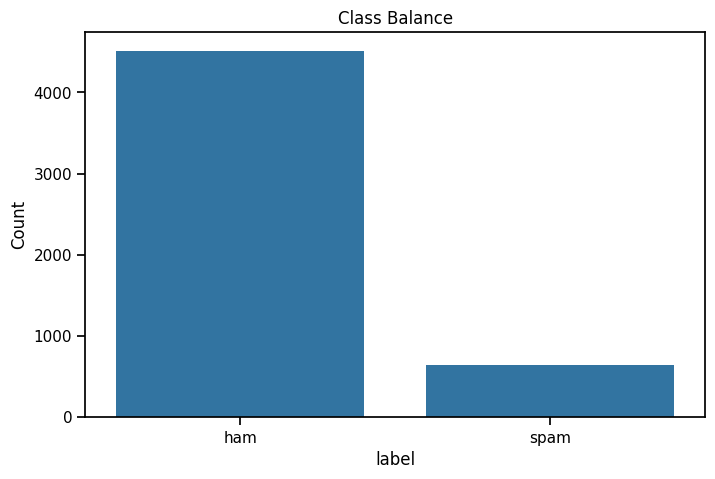

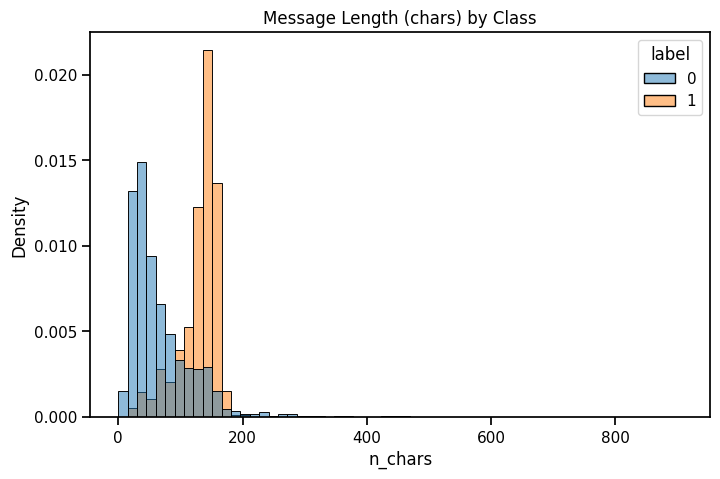

n_chars                                                n_words        \
        count   mean   std   min    25%    50%    75%    max   count  mean   
label                                                                        
0      4516.0   67.4  54.3   0.0   32.0   50.0   87.0  907.0  4516.0  14.7   
1       642.0  130.2  31.0  16.0  119.0  140.5  151.0  208.0   642.0  26.9   

                                           
        std  min   25%   50%   75%    max  
label                                      
0      11.5  0.0   7.0  11.0  19.0  190.0  
1       7.0  2.0  24.0  28.0  31.0   43.0

In [4]:
def basic_clean(text: str) -> str:
    text = text.lower()
    text = re.sub(r"http\S+|www\.\S+", " URL ", text)   # urls
    text = re.sub(r"\S+@\S+", " EMAIL ", text)           # emails
    text = re.sub(r"\d+", " NUM ", text)                 # numbers
    text = re.sub(r"[^\w\s]", " ", text)                 # punctuation
    text = re.sub(r"\s+", " ", text).strip()
    return text

df["text_clean"] = df["text"].apply(basic_clean)

# Basic stats
df["n_chars"] = df["text_clean"].str.len()
df["n_words"] = df["text_clean"].str.split().str.len()

# Class balance
counts = df["label"].value_counts().rename({0:"ham",1:"spam"})
sns.barplot(x=counts.index, y=counts.values)
plt.title("Class Balance"); plt.ylabel("Count")
plt.show()

# Message length distributions
sns.histplot(df, x="n_chars", hue="label", bins=60, stat="density", common_norm=False)
plt.title("Message Length (chars) by Class")
plt.show()

df[["n_chars","n_words","label"]].groupby("label").describe().round(1)


In [5]:
# First split: train+temp vs test
X_full = df["text_clean"].values
y_full = df["label"].values

X_train, X_temp, y_train, y_temp = train_test_split(
    X_full, y_full, test_size=0.30, random_state=RANDOM_STATE, stratify=y_full
)

# Second split: validation vs test (from temp)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=RANDOM_STATE, stratify=y_temp
)

len(X_train), len(X_val), len(X_test)


(3610, 774, 774)

In [6]:
dummy = Pipeline([
    ("tfidf", TfidfVectorizer(ngram_range=(1,1))),
    ("clf", DummyClassifier(strategy="most_frequent", random_state=RANDOM_STATE))
])
dummy.fit(X_train, y_train)
pred = dummy.predict(X_val)
print("Baseline (Most Frequent) — Val F1:", f1_score(y_val, pred))


Baseline (Most Frequent) — Val F1: 0.0


In [7]:
nb_pipe = Pipeline([
    ("tfidf", TfidfVectorizer(ngram_range=(1,2), min_df=2)),
    ("clf", MultinomialNB())
])

nb_pipe.fit(X_train, y_train)
pred = nb_pipe.predict(X_val)

print("MultinomialNB — Validation")
print("Accuracy :", accuracy_score(y_val, pred))
print("Precision:", precision_score(y_val, pred))
print("Recall   :", recall_score(y_val, pred))
print("F1       :", f1_score(y_val, pred))
print()
print(classification_report(y_val, pred, target_names=["ham","spam"]))


MultinomialNB — Validation
Accuracy : 0.9689922480620154
Precision: 1.0
Recall   : 0.7525773195876289
F1       : 0.8588235294117647

              precision    recall  f1-score   support

         ham       0.97      1.00      0.98       677
        spam       1.00      0.75      0.86        97

    accuracy                           0.97       774
   macro avg       0.98      0.88      0.92       774
weighted avg       0.97      0.97      0.97       774



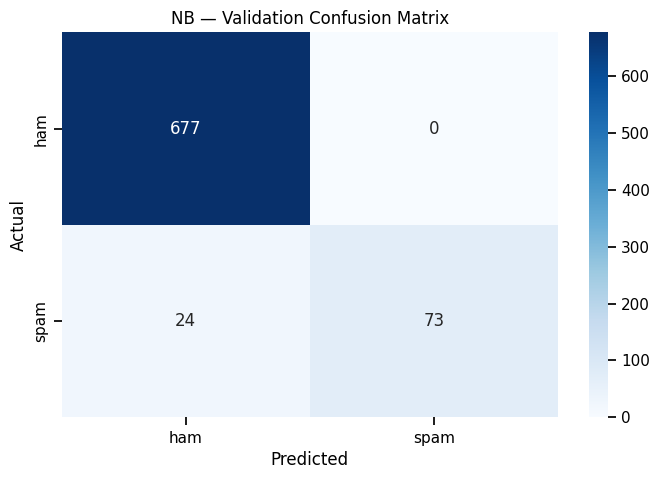

In [8]:
def plot_cm(y_true, y_pred, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=["ham","spam"], yticklabels=["ham","spam"])
    plt.xlabel("Predicted"); plt.ylabel("Actual"); plt.title(title); plt.show()

plot_cm(y_val, pred, "NB — Validation Confusion Matrix")


In [9]:
models = {
    "MultinomialNB": MultinomialNB(),
    "LogReg": LogisticRegression(max_iter=600, class_weight="balanced"),
    "LinearSVM": LinearSVC()
}

def build_pipe(clf):
    return Pipeline([
        ("tfidf", TfidfVectorizer(ngram_range=(1,2), min_df=2)),
        ("clf", clf)
    ])

def eval_on_val(name, pipe):
    pipe.fit(X_train, y_train)
    p = pipe.predict(X_val)
    acc = accuracy_score(y_val, p)
    prec = precision_score(y_val, p)
    rec = recall_score(y_val, p)
    f1 = f1_score(y_val, p)
    print(f"{name:12s} Acc={acc:.3f}  Prec={prec:.3f}  Rec={rec:.3f}  F1={f1:.3f}")
    return {"Model": name, "Accuracy": acc, "Precision": prec, "Recall": rec, "F1": f1}, pipe

results, fitted = [], {}
for name, clf in models.items():
    r, pipe = eval_on_val(name, build_pipe(clf))
    results.append(r); fitted[name] = pipe

pd.DataFrame(results).sort_values("F1", ascending=False)


MultinomialNB Acc=0.969  Prec=1.000  Rec=0.753  F1=0.859
LogReg       Acc=0.972  Prec=0.857  Rec=0.928  F1=0.891
LinearSVM    Acc=0.986  Prec=0.967  Rec=0.918  F1=0.942


,Model,Accuracy,Precision,Recall,F1
2,LinearSVM,0.985788,0.967391,0.917526,0.941799
1,LogReg,0.971576,0.857143,0.927835,0.891089
0,MultinomialNB,0.968992,1.000000,0.752577,0.858824


In [10]:
# Ensure we have a probability model (LogReg)
lr_pipe = build_pipe(LogisticRegression(max_iter=600, class_weight="balanced"))
lr_pipe.fit(X_train, y_train)

# Get spam probability on validation
proba = lr_pipe.predict_proba(X_val)[:, 1]

precisions, recalls, thresholds = precision_recall_curve(y_val, proba)
ap = average_precision_score(y_val, proba)
print("Average Precision (area under PR curve):", round(ap, 4))

# Choose threshold that maximizes F1 on validation
best_t, best_f1 = 0.5, -1
for t in np.linspace(0.1, 0.9, 81):
    p = (proba >= t).astype(int)
    f1 = f1_score(y_val, p)
    if f1 > best_f1:
        best_f1, best_t = f1, t

print(f"Best threshold on val: {best_t:.2f} → F1={best_f1:.3f}")


Average Precision (area under PR curve): 0.9423
Best threshold on val: 0.65 → F1=0.917



MultinomialNB — TEST
Accuracy : 0.9715762273901809
Precision: 1.0
Recall   : 0.7708333333333334
F1       : 0.8705882352941177

LogReg @ t=0.65 — TEST
Accuracy : 0.9819121447028424
Precision: 0.9183673469387755
Recall   : 0.9375
F1       : 0.9278350515463918

LinearSVM — TEST
Accuracy : 0.9909560723514211
Precision: 0.968421052631579
Recall   : 0.9583333333333334
F1       : 0.9633507853403142


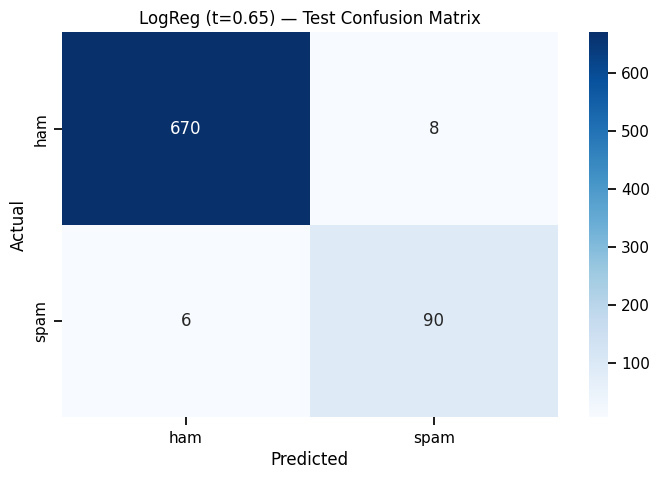

In [11]:
# NB (discrete)
nb_pred_test = fitted["MultinomialNB"].predict(X_test)

# Logistic (with tuned threshold)
lr_proba_test = lr_pipe.predict_proba(X_test)[:, 1]
lr_pred_test  = (lr_proba_test >= best_t).astype(int)

# Linear SVM (discrete)
svm_pred_test = fitted["LinearSVM"].predict(X_test)

def summarize(name, y_true, y_pred):
    print(f"\n{name} — TEST")
    print("Accuracy :", accuracy_score(y_true, y_pred))
    print("Precision:", precision_score(y_true, y_pred))
    print("Recall   :", recall_score(y_true, y_pred))
    print("F1       :", f1_score(y_true, y_pred))

summarize("MultinomialNB", y_test, nb_pred_test)
summarize(f"LogReg @ t={best_t:.2f}", y_test, lr_pred_test)
summarize("LinearSVM", y_test, svm_pred_test)

plot_cm(y_test, lr_pred_test, f"LogReg (t={best_t:.2f}) — Test Confusion Matrix")


In [12]:
# Fit simple CountVectorizer to see top tokens
cv = CountVectorizer(min_df=3, ngram_range=(1,2))
X_counts = cv.fit_transform(df["text_clean"])
vocab = np.array(cv.get_feature_names_out())

# NB-style log-count ratio (spam vs ham)
spam_idx = (df["label"].values == 1)
ham_idx  = ~spam_idx

spam_counts = np.asarray(X_counts[spam_idx].sum(axis=0)).ravel() + 1
ham_counts  = np.asarray(X_counts[ham_idx].sum(axis=0)).ravel()  + 1
log_ratio = np.log(spam_counts / ham_counts)

top_spam = vocab[log_ratio.argsort()[::-1][:20]]
top_ham  = vocab[log_ratio.argsort()[:20]]

print("Top spam-indicative tokens:\n", top_spam)
print("\nTop ham-indicative tokens:\n", top_ham)

# Logistic Regression coefficients
lr = LogisticRegression(max_iter=600, class_weight="balanced")
pipe_lr = Pipeline([("tfidf", TfidfVectorizer(ngram_range=(1,2), min_df=2)), ("clf", lr)])
pipe_lr.fit(X_train, y_train)

feature_names = pipe_lr.named_steps["tfidf"].get_feature_names_out()
coefs = pipe_lr.named_steps["clf"].coef_.ravel()
top_pos_idx = np.argsort(coefs)[-20:]      # spam
top_neg_idx = np.argsort(coefs)[:20]       # ham

print("\nLogReg: top spam words:\n", feature_names[top_pos_idx])
print("\nLogReg: top ham words:\n", feature_names[top_neg_idx])


Top spam-indicative tokens:
 ['claim' 'prize' 'call num' 'num now' 'box num' 'your mobile' 'num cash'
 'have won' 'num prize' 'tone' 'guaranteed' 'ppm' 'to claim' 'num ppm'
 'cs' 'pobox num' 'awarded' 'pobox' 'your num' 'or call']

Top ham-indicative tokens:
 ['gt' 'lt' 'lt gt' 'he' 'lor' 'she' 'ì_' 'later' 'ask' 'say' 'doing'
 'said' 'cos' 'lol' 'going to' 'anything' 'da' 'have to' 'come' 'sure']

LogReg: top spam words:
 ['message' 'ringtone' 'with' 'sms' 'num num' 'service' 'txt' 'stop' 'for'
 'reply' 'mobile' 'to num' 'call' 'call num' 'free' 'to' 'text' 'your'
 'url' 'num']

LogReg: top ham words:
 ['me' 'my' 'lt' 'but' 'gt' 'got' 'lt gt' 'ok' 'at' 'that' 'he' 'da' 'lor'
 'when' 'can' 'home' 'then' 'at num' 'how' 'sorry']


In [13]:
# Use the tuned Logistic Regression predictions
test_text = pd.Series(X_test)
pred = lr_pred_test

mistakes = pd.DataFrame({
    "text": test_text,
    "true": y_test,
    "pred": pred
})
fp = mistakes[(mistakes["true"]==0) & (mistakes["pred"]==1)].head(5)
fn = mistakes[(mistakes["true"]==1) & (mistakes["pred"]==0)].head(5)

print("False Positives (ham predicted as spam):")
display(fp)

print("\nFalse Negatives (spam predicted as ham):")
display(fn)


False Positives (ham predicted as spam):


,text,true,pred
112,funny fact nobody teaches volcanoes NUM erupt ...,0,1
305,yep then is fine NUM NUM or NUM NUM for ice age,0,1
443,is toshiba portege m NUM gd,0,1
523,v nice off NUM sheffield tom NUM air my opinio...,0,1
607,and picking them up from various points going ...,0,1



False Negatives (spam predicted as ham):


,text,true,pred
163,themob yo yo yo here comes a new selection of ...,1,0
205,freemsg fav xmas tones reply real,1,0
213,xmas new years eve tickets are now on sale fro...,1,0
477,cashbin co uk get lots of cash this weekend UR...,1,0
596,sorry i missed your call let s talk when you h...,1,0


In [14]:
# Choose your favorite (here we save the tuned Logistic Regression pipeline)
# We’ll wrap threshold inside a tiny dict of metadata.
art_dir = Path("artifacts"); art_dir.mkdir(exist_ok=True)

final_artifact = {
    "pipeline": lr_pipe,
    "threshold": float(best_t),
    "notes": "TF-IDF + LogisticRegression with tuned threshold on validation set."
}

joblib.dump(final_artifact, art_dir / "spam_detector.joblib")
print("Saved → artifacts/spam_detector.joblib")


Saved → artifacts/spam_detector.joblib


In [15]:
loaded = joblib.load("artifacts/spam_detector.joblib")
pipe = loaded["pipeline"]; thr = loaded["threshold"]

def basic_clean(text: str) -> str:
    text = text.lower()
    text = re.sub(r"http\S+|www\.\S+", " URL ", text)
    text = re.sub(r"\S+@\S+", " EMAIL ", text)
    text = re.sub(r"\d+", " NUM ", text)
    text = re.sub(r"[^\w\s]", " ", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

def predict_emails(texts):
    if isinstance(texts, str): texts = [texts]
    cleaned = [basic_clean(t) for t in texts]
    if hasattr(pipe.named_steps["clf"], "predict_proba"):
        p = pipe.predict_proba(cleaned)[:, 1]
        labels = (p >= thr).astype(int)
        return labels, p
    else:
        labels = pipe.predict(cleaned)
        return labels, None

samples = [
    "Congratulations! You've won a $1000 gift card. Click now: http://x.co/win",
    "Hi John, can you review the meeting notes I emailed yesterday?"
]
labels, probs = predict_emails(samples)
for s, lb, pr in zip(samples, labels, probs if probs is not None else [None]*len(samples)):
    print("\n>>>", s)
    print("Prediction:", "spam" if lb==1 else "ham",
          (f"(spam prob={pr:.2f})" if pr is not None else ""))



>>> Congratulations! You've won a $1000 gift card. Click now: http://x.co/win
Prediction: spam (spam prob=0.68)

>>> Hi John, can you review the meeting notes I emailed yesterday?
Prediction: ham (spam prob=0.06)


In [16]:
with open("artifacts/model_card.txt","w",encoding="utf-8") as f:
    f.write("Model Card — Spam Detector\n")
    f.write("==========================\n\n")
    f.write("• Data: spam.csv (cleaned, deduped)\n")
    f.write("• Labels: ham=0, spam=1\n")
    f.write("• Pipeline: TfidfVectorizer(1-2 grams, min_df=2) + LogisticRegression(balanced)\n")
    f.write(f"• Tuned threshold: {best_t:.2f} (chosen on validation set)\n\n")
    f.write("• Test metrics (LogReg @ tuned threshold):\n")
    f.write(f"  Accuracy={accuracy_score(y_test, lr_pred_test):.3f}\n")
    f.write(f"  Precision={precision_score(y_test, lr_pred_test):.3f}\n")
    f.write(f"  Recall={recall_score(y_test, lr_pred_test):.3f}\n")
    f.write(f"  F1={f1_score(y_test, lr_pred_test):.3f}\n\n")
    f.write("• Notes: Threshold tuning improves the precision/recall tradeoff.\n")
print("Wrote → artifacts/model_card.txt")


Wrote → artifacts/model_card.txt


In [17]:
%%writefile app.py
import re, joblib
import streamlit as st

def basic_clean(text: str) -> str:
    text = text.lower()
    text = re.sub(r"http\S+|www\.\S+", " URL ", text)
    text = re.sub(r"\S+@\S+", " EMAIL ", text)
    text = re.sub(r"\d+", " NUM ", text)
    text = re.sub(r"[^\w\s]", " ", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

st.title("📧 Email Spam Detector")
artifact = joblib.load("artifacts/spam_detector.joblib")
pipe, thr = artifact["pipeline"], artifact["threshold"]

text = st.text_area("Paste email text here")
if st.button("Predict"):
    x = [basic_clean(text)]
    if hasattr(pipe.named_steps["clf"], "predict_proba"):
        p = pipe.predict_proba(x)[:,1][0]
        pred = int(p >= thr)
        st.write("Prediction:", "🚫 Spam" if pred else "✅ Ham")
        st.write(f"Spam probability: {p:.2f} (threshold={thr:.2f})")
    else:
        pred = pipe.predict(x)[0]
        st.write("Prediction:", "🚫 Spam" if pred else "✅ Ham")

# Run it with: streamlit run app.py


Writing app.py
